In [1]:
!pip install -q torch transformers numpy matplotlib scipy tqdm scikit-learn

import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [2]:
model_name = "gpt2-medium"

print(f"Loading model: {model_name}...")
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
model.to(device)
model.eval()
print("Model loaded successfully!\n")


Loading model: gpt2-medium...


config.json:   0%|          | 0.00/718 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.52G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model loaded successfully!



In [3]:
true_statements = [
    # Geography
    "Paris is the capital of France",
    "The Pacific Ocean is the largest ocean on Earth",
    "Mount Everest is the tallest mountain in the world",
    "The Nile River is located in Africa",
    "Australia is both a country and a continent",
    "Tokyo is the capital of Japan",
    "The Amazon rainforest is in South America",
    "The Great Wall of China is in Asia",

    # Science
    "Water boils at 100 degrees Celsius at sea level",
    "The Earth orbits around the Sun",
    "Light travels faster than sound",
    "Humans have 46 chromosomes",
    "Gold is a chemical element with symbol Au",
    "Oxygen is necessary for human respiration",
    "The speed of light is approximately 300,000 kilometers per second",
    "Gravity causes objects to fall toward the Earth",

    # History
    "World War II ended in 1945",
    "The United States Declaration of Independence was signed in 1776",
    "Julius Caesar was a Roman emperor",
    "The Berlin Wall fell in 1989",
    "Christopher Columbus sailed to the Americas in 1492",

    # Mathematics
    "Two plus two equals four",
    "A triangle has three sides",
    "Pi is approximately 3.14159",
    "Ten multiplied by ten equals one hundred",
    "A square has four equal sides",

    # Biology
    "The human heart pumps blood",
    "Dolphins are mammals",
    "Plants perform photosynthesis",
    "DNA carries genetic information",
    "Birds lay eggs",
]

# False statements (factually incorrect)
false_statements = [
    # Geography (False)
    "London is the capital of Germany",
    "The Atlantic Ocean is the largest ocean on Earth",
    "Mount Kilimanjaro is the tallest mountain in the world",
    "The Nile River is located in Asia",
    "Europe is both a country and a continent",
    "Beijing is the capital of South Korea",
    "The Amazon rainforest is in Africa",
    "The Great Wall of China is in Europe",

    # Science (False)
    "Water boils at 50 degrees Celsius at sea level",
    "The Sun orbits around the Earth",
    "Sound travels faster than light",
    "Humans have 32 chromosomes",
    "Gold is a chemical element with symbol Ag",
    "Carbon dioxide is necessary for human respiration",
    "The speed of light is approximately 30,000 kilometers per second",
    "Magnetism causes objects to fall toward the Earth",

    # History (False)
    "World War II ended in 1950",
    "The United States Declaration of Independence was signed in 1876",
    "Julius Caesar was a Greek philosopher",
    "The Berlin Wall fell in 1999",
    "Christopher Columbus sailed to the Americas in 1592",

    # Mathematics (False)
    "Two plus two equals five",
    "A triangle has four sides",
    "Pi is approximately 2.14159",
    "Ten multiplied by ten equals fifty",
    "A square has three equal sides",

    # Biology (False)
    "The human heart produces electricity",
    "Dolphins are reptiles",
    "Plants perform respiration only",
    "RNA carries genetic information exclusively",
    "Birds give birth to live young",
]

print(f"Created dataset with {len(true_statements)} true and {len(false_statements)} false statements\n")


Created dataset with 31 true and 31 false statements



In [4]:
def get_layer_activations(model, tokenizer, prompts, layer_indices=None):
    if layer_indices is None:
        num_layers = len(model.transformer.h)
        layer_indices = [num_layers - 1, num_layers - 5, num_layers - 9,
                        num_layers - 13, num_layers // 2]

    layer_activations = {idx: [] for idx in layer_indices}

    with torch.no_grad():
        for prompt in tqdm(prompts, desc="Extracting activations"):
            inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=128)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs, output_hidden_states=True)

            for layer_idx in layer_indices:
                hidden_state = outputs.hidden_states[layer_idx]
                last_token_activation = hidden_state[0, -1, :].cpu()
                layer_activations[layer_idx].append(last_token_activation)

    for layer_idx in layer_indices:
        layer_activations[layer_idx] = torch.stack(layer_activations[layer_idx])

    return layer_activations

print("Extracting activations for TRUE statements...")
true_activations = get_layer_activations(model, tokenizer, true_statements)

print("Extracting activations for FALSE statements...")
false_activations = get_layer_activations(model, tokenizer, false_statements)

print("\nActivation extraction complete!")
for layer_idx in true_activations.keys():
    print(f"Layer {layer_idx}: {true_activations[layer_idx].shape}")


Extracting activations for TRUE statements...


Extracting activations: 100%|██████████| 31/31 [00:02<00:00, 15.03it/s]


Extracting activations for FALSE statements...


Extracting activations: 100%|██████████| 31/31 [00:01<00:00, 22.23it/s]


Activation extraction complete!
Layer 23: torch.Size([31, 1024])
Layer 19: torch.Size([31, 1024])
Layer 15: torch.Size([31, 1024])
Layer 11: torch.Size([31, 1024])
Layer 12: torch.Size([31, 1024])


In [5]:
truthfulness_directions = {}
truthfulness_directions_normalized = {}

for layer_idx in true_activations.keys():
    mean_true = true_activations[layer_idx].mean(dim=0)
    mean_false = false_activations[layer_idx].mean(dim=0)

    truth_dir = mean_true - mean_false
    truth_dir_norm = truth_dir / truth_dir.norm()

    truthfulness_directions[layer_idx] = truth_dir
    truthfulness_directions_normalized[layer_idx] = truth_dir_norm

    print(f"Layer {layer_idx} - Truthfulness direction norm: {truth_dir.norm().item():.4f}")


Layer 23 - Truthfulness direction norm: 24.2431
Layer 19 - Truthfulness direction norm: 19.2082
Layer 15 - Truthfulness direction norm: 16.2689
Layer 11 - Truthfulness direction norm: 13.7239
Layer 12 - Truthfulness direction norm: 14.4868


In [6]:
def project_onto_direction(activations_dict, direction_dict):
    projections = {}
    for layer_idx in activations_dict.keys():
        activations = activations_dict[layer_idx]
        direction = direction_dict[layer_idx]
        projections[layer_idx] = torch.matmul(activations, direction)
    return projections

true_projections = project_onto_direction(true_activations, truthfulness_directions_normalized)
false_projections = project_onto_direction(false_activations, truthfulness_directions_normalized)

print("PROJECTION ANALYSIS")

for layer_idx in true_projections.keys():
    true_proj_mean = true_projections[layer_idx].mean().item()
    false_proj_mean = false_projections[layer_idx].mean().item()
    separation = true_proj_mean - false_proj_mean

    print(f"\nLayer {layer_idx}:")
    print(f"  Mean projection (TRUE):  {true_proj_mean:7.4f}")
    print(f"  Mean projection (FALSE): {false_proj_mean:7.4f}")
    print(f"  Separation:              {separation:7.4f}")


PROJECTION ANALYSIS

Layer 23:
  Mean projection (TRUE):  162.1582
  Mean projection (FALSE): 137.9151
  Separation:              24.2431

Layer 19:
  Mean projection (TRUE):  38.2306
  Mean projection (FALSE): 19.0224
  Separation:              19.2082

Layer 15:
  Mean projection (TRUE):  24.6455
  Mean projection (FALSE):  8.3766
  Separation:              16.2689

Layer 11:
  Mean projection (TRUE):  34.8366
  Mean projection (FALSE): 21.1127
  Separation:              13.7239

Layer 12:
  Mean projection (TRUE):  29.6993
  Mean projection (FALSE): 15.2125
  Separation:              14.4868



Best layer for truthfulness detection: Layer 23


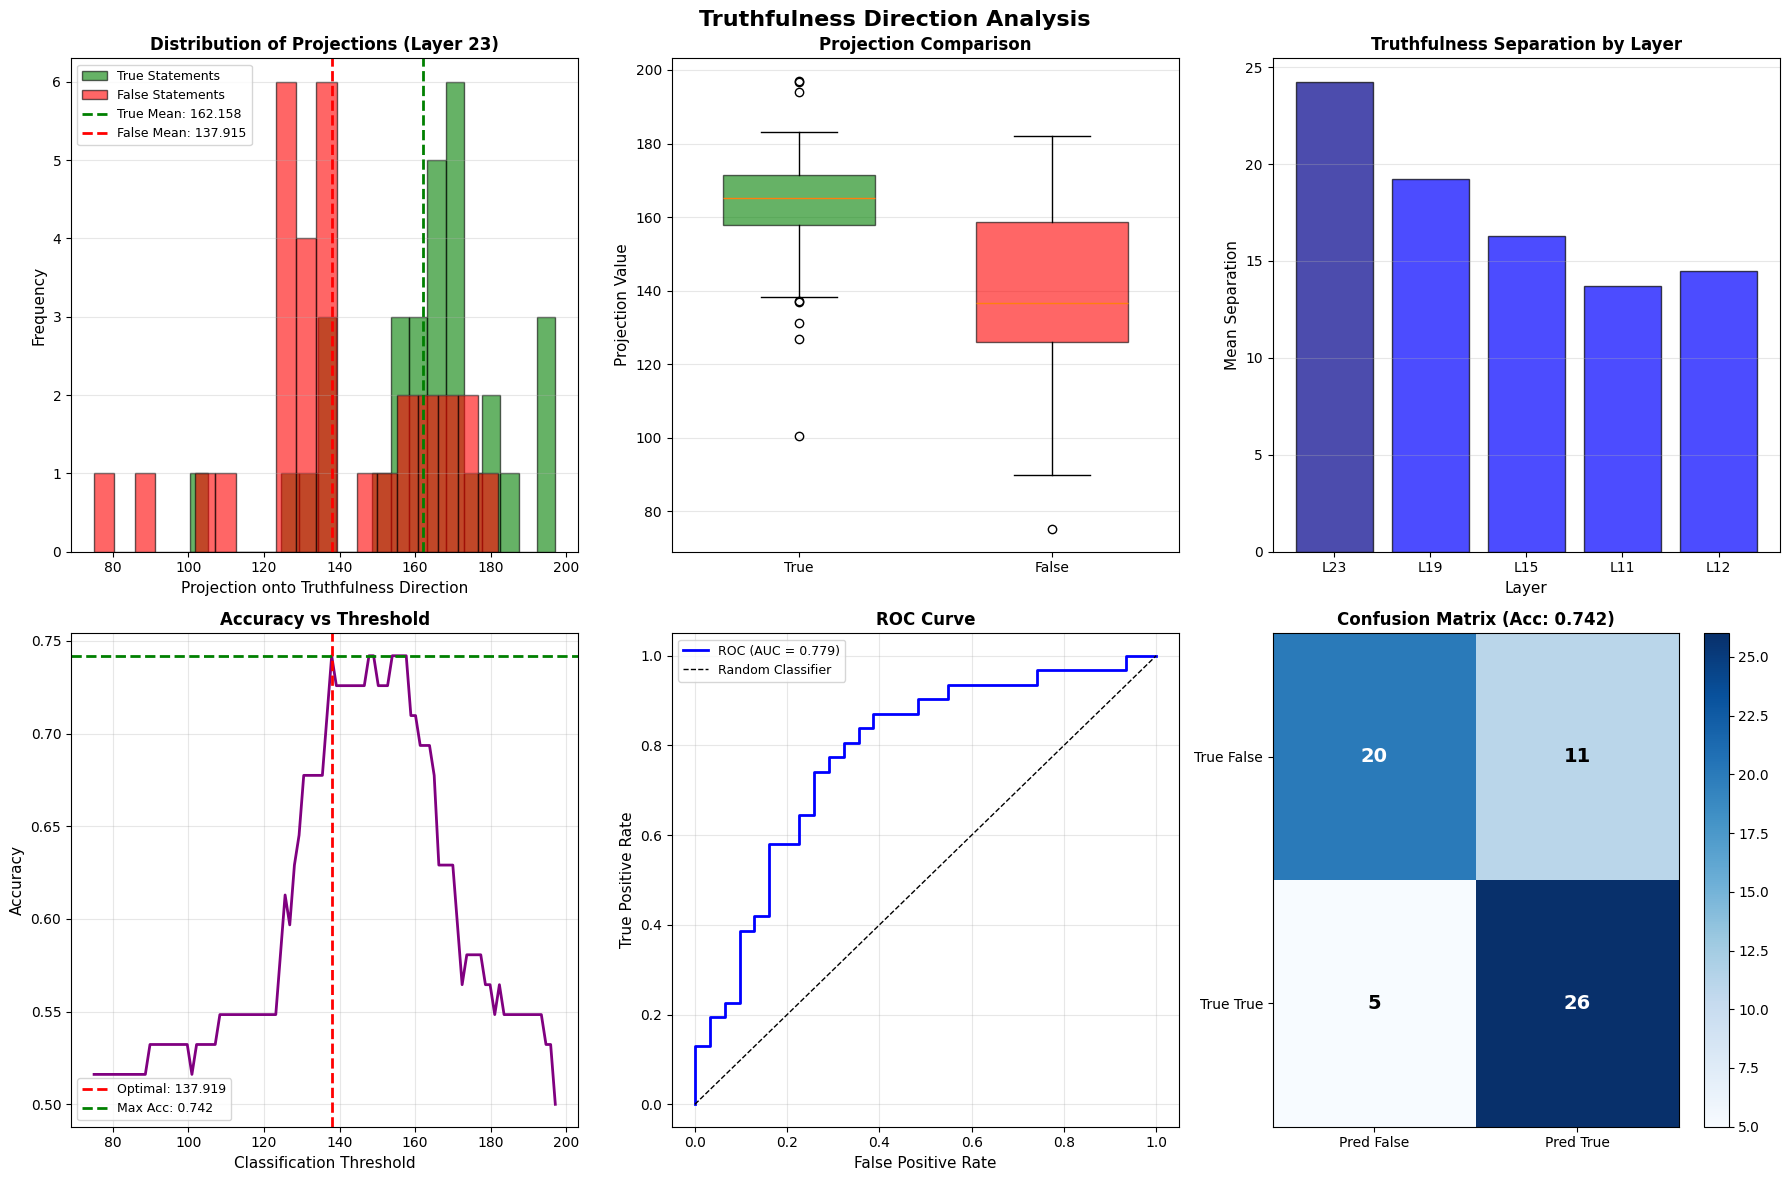


Key Findings:
  - Best Layer: 23
  - Optimal Threshold: 137.9191
  - Maximum Accuracy: 0.7419
  - AUC Score: 0.7794


In [7]:
best_layer = max(true_projections.keys(),
                 key=lambda k: (true_projections[k].mean() - false_projections[k].mean()).item())

print(f"\nBest layer for truthfulness detection: Layer {best_layer}")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Truthfulness Direction Analysis', fontsize=16, fontweight='bold')

ax = axes[0, 0]
true_proj = true_projections[best_layer].numpy()
false_proj = false_projections[best_layer].numpy()

ax.hist(true_proj, bins=20, alpha=0.6, label='True Statements', color='green', edgecolor='black')
ax.hist(false_proj, bins=20, alpha=0.6, label='False Statements', color='red', edgecolor='black')
ax.axvline(true_proj.mean(), color='green', linestyle='--', linewidth=2, label=f'True Mean: {true_proj.mean():.3f}')
ax.axvline(false_proj.mean(), color='red', linestyle='--', linewidth=2, label=f'False Mean: {false_proj.mean():.3f}')
ax.set_xlabel('Projection onto Truthfulness Direction', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Distribution of Projections (Layer {best_layer})', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 1]
box_data = [true_proj, false_proj]
box = ax.boxplot(box_data, labels=['True', 'False'], patch_artist=True, widths=0.6)
box['boxes'][0].set_facecolor('green')
box['boxes'][0].set_alpha(0.6)
box['boxes'][1].set_facecolor('red')
box['boxes'][1].set_alpha(0.6)
ax.set_ylabel('Projection Value', fontsize=11)
ax.set_title('Projection Comparison', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

ax = axes[0, 2]
layer_names = list(true_projections.keys())
separations = [(true_projections[k].mean() - false_projections[k].mean()).item()
               for k in layer_names]
colors = ['blue' if k != best_layer else 'darkblue' for k in layer_names]
ax.bar(range(len(layer_names)), separations, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(layer_names)))
ax.set_xticklabels([f'L{k}' for k in layer_names])
ax.set_xlabel('Layer', fontsize=11)
ax.set_ylabel('Mean Separation', fontsize=11)
ax.set_title('Truthfulness Separation by Layer', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(0, color='black', linestyle='-', linewidth=0.5)

ax = axes[1, 0]
thresholds = np.linspace(false_proj.min(), true_proj.max(), 100)
accuracies = []
for thresh in thresholds:
    true_correct = (true_proj > thresh).sum()
    false_correct = (false_proj <= thresh).sum()
    acc = (true_correct + false_correct) / (len(true_proj) + len(false_proj))
    accuracies.append(acc)

optimal_idx = np.argmax(accuracies)
optimal_threshold = thresholds[optimal_idx]
max_accuracy = accuracies[optimal_idx]

ax.plot(thresholds, accuracies, linewidth=2, color='purple')
ax.axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
          label=f'Optimal: {optimal_threshold:.3f}')
ax.axhline(max_accuracy, color='green', linestyle='--', linewidth=2,
          label=f'Max Acc: {max_accuracy:.3f}')
ax.set_xlabel('Classification Threshold', fontsize=11)
ax.set_ylabel('Accuracy', fontsize=11)
ax.set_title('Accuracy vs Threshold', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

ax = axes[1, 1]
y_true = np.concatenate([np.ones(len(true_proj)), np.zeros(len(false_proj))])
y_scores = np.concatenate([true_proj, false_proj])
fpr, tpr, _ = roc_curve(y_true, y_scores)
auc = roc_auc_score(y_true, y_scores)

ax.plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.3f})', color='blue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=11)
ax.set_ylabel('True Positive Rate', fontsize=11)
ax.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(alpha=0.3)

ax = axes[1, 2]
y_pred = (y_scores > optimal_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred)
im = ax.imshow(cm, cmap='Blues', aspect='auto')
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Pred False', 'Pred True'])
ax.set_yticklabels(['True False', 'True True'])
ax.set_title(f'Confusion Matrix (Acc: {max_accuracy:.3f})', fontsize=12, fontweight='bold')

for i in range(2):
    for j in range(2):
        text = ax.text(j, i, cm[i, j], ha="center", va="center",
                      color="white" if cm[i, j] > cm.max()/2 else "black",
                      fontsize=14, fontweight='bold')

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig('truthfulness_direction_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nKey Findings:")
print(f"  - Best Layer: {best_layer}")
print(f"  - Optimal Threshold: {optimal_threshold:.4f}")
print(f"  - Maximum Accuracy: {max_accuracy:.4f}")
print(f"  - AUC Score: {auc:.4f}")


In [8]:
print("TESTING TRUTHFULNESS DIRECTION ON NEW STATEMENTS")

test_statements = [
    ("The moon orbits the Earth", True),
    ("The moon orbits Mars", False),
    ("Cats are mammals", True),
    ("Cats are reptiles", False),
    ("Ice melts at zero degrees Celsius", True),
    ("Ice melts at fifty degrees Celsius", False),
    ("Shakespeare wrote Hamlet", True),
    ("Shakespeare wrote The Odyssey", False),
    ("The human body has 206 bones", True),
    ("The human body has 500 bones", False),
]

print("\nExtracting activations for test statements...")
test_texts = [stmt for stmt, _ in test_statements]
test_labels = [label for _, label in test_statements]

with torch.no_grad():
    test_activations = []
    for text in tqdm(test_texts):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs, output_hidden_states=True)
        activation = outputs.hidden_states[best_layer][0, -1, :].cpu()
        test_activations.append(activation)

    test_activations = torch.stack(test_activations)

test_projections = torch.matmul(test_activations, truthfulness_directions_normalized[best_layer])
test_predictions = (test_projections > optimal_threshold).numpy()

print("RESULTS:")

correct = 0
for i, (text, true_label) in enumerate(test_statements):
    proj_value = test_projections[i].item()
    predicted = test_predictions[i]
    is_correct = (predicted == true_label)
    correct += is_correct

    status = "✓ CORRECT" if is_correct else "✗ WRONG"
    print(f"\n{status}")
    print(f"  Statement: '{text}'")
    print(f"  True Label: {true_label}, Predicted: {predicted}")
    print(f"  Projection: {proj_value:.4f} (threshold: {optimal_threshold:.4f})")

accuracy = correct / len(test_statements)
print(f"Test Accuracy: {accuracy:.2%} ({correct}/{len(test_statements)} correct)")


TESTING TRUTHFULNESS DIRECTION ON NEW STATEMENTS

Extracting activations for test statements...


100%|██████████| 10/10 [00:00<00:00, 20.70it/s]

RESULTS:

✓ CORRECT
  Statement: 'The moon orbits the Earth'
  True Label: True, Predicted: True
  Projection: 138.6492 (threshold: 137.9191)

✗ WRONG
  Statement: 'The moon orbits Mars'
  True Label: False, Predicted: True
  Projection: 140.5181 (threshold: 137.9191)

✓ CORRECT
  Statement: 'Cats are mammals'
  True Label: True, Predicted: True
  Projection: 165.9512 (threshold: 137.9191)

✗ WRONG
  Statement: 'Cats are reptiles'
  True Label: False, Predicted: True
  Projection: 144.0618 (threshold: 137.9191)

✓ CORRECT
  Statement: 'Ice melts at zero degrees Celsius'
  True Label: True, Predicted: True
  Projection: 174.0289 (threshold: 137.9191)

✗ WRONG
  Statement: 'Ice melts at fifty degrees Celsius'
  True Label: False, Predicted: True
  Projection: 172.1175 (threshold: 137.9191)

✓ CORRECT
  Statement: 'Shakespeare wrote Hamlet'
  True Label: True, Predicted: True
  Projection: 153.4045 (threshold: 137.9191)

✓ CORRECT
  Statement: 'Shakespeare wrote The Odyssey'
  True Label:

In [9]:
print("EXPERIMENT 1: ACTIVATION ADDITION (Enhancing Truthfulness)")

print("""
Hypothesis: Adding the truthfulness direction should make the model:
  1. More confident about true statements
  2. Less confident about false statements
  3. Generally favor factually accurate completions
""")

generation_prompts = [
    "The capital of France is",
    "Water boils at",
    "The Earth orbits around the",
]

print("\nGenerating completions WITHOUT intervention...")
baseline_completions = []
for prompt in generation_prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model.generate(**inputs, max_length=20, do_sample=False, pad_token_id=tokenizer.eos_token_id)
    completion = tokenizer.decode(outputs[0], skip_special_tokens=True)
    baseline_completions.append(completion)
    print(f"  Prompt: '{prompt}'")
    print(f"  → {completion}\n")

EXPERIMENT 1: ACTIVATION ADDITION (Enhancing Truthfulness)

Hypothesis: Adding the truthfulness direction should make the model:
  1. More confident about true statements
  2. Less confident about false statements
  3. Generally favor factually accurate completions


Generating completions WITHOUT intervention...
  Prompt: 'The capital of France is'
  → The capital of France is Paris, and the capital of France is Paris.

The capital of

  Prompt: 'Water boils at'
  → Water boils at a temperature of about 1,000 degrees Fahrenheit.

The water is heated to

  Prompt: 'The Earth orbits around the'
  → The Earth orbits around the Sun at a distance of about 1.5 million miles (2.5



EXPERIMENT 2: DIRECTIONAL ABLATION (Removing Truthfulness)

Hypothesis: Ablating the truthfulness direction should:
  1. Make the model unable to distinguish true from false
  2. Potentially increase generation of false statements
  3. Reduce the separation in activation projections


Original projection mean: 152.5518
Ablated projection mean:  0.0000
Reduction: 152.5518


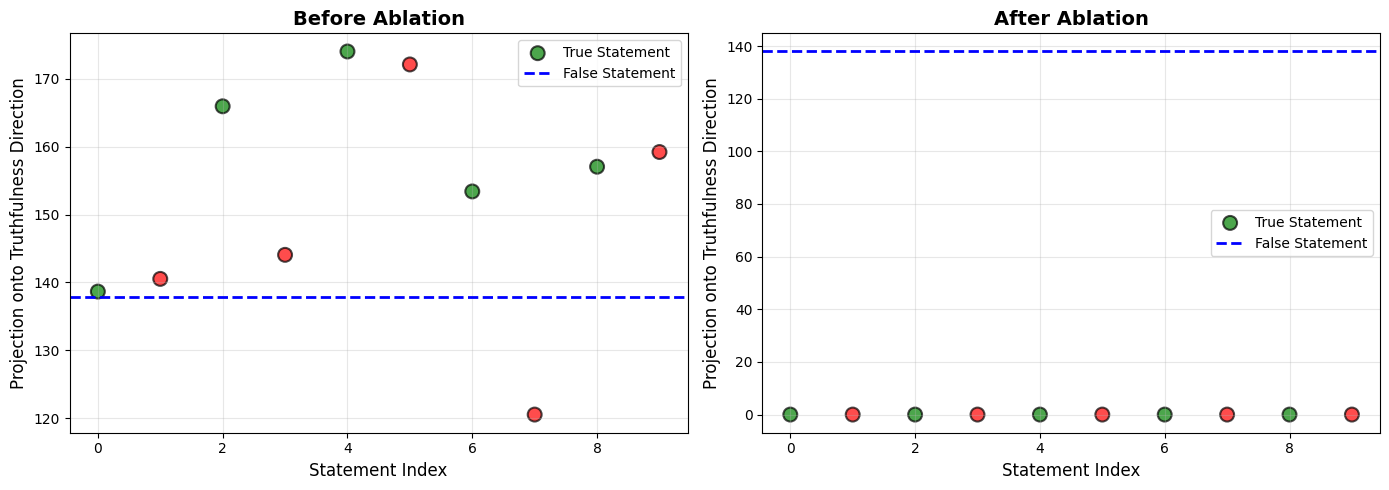

In [10]:
print("EXPERIMENT 2: DIRECTIONAL ABLATION (Removing Truthfulness)")

print("""
Hypothesis: Ablating the truthfulness direction should:
  1. Make the model unable to distinguish true from false
  2. Potentially increase generation of false statements
  3. Reduce the separation in activation projections
""")

def ablate_direction(activations, direction):
    direction = direction / direction.norm()
    projection = torch.matmul(activations, direction.unsqueeze(1))
    ablated = activations - projection * direction.unsqueeze(0)
    return ablated

ablated_test_activations = ablate_direction(test_activations,
                                            truthfulness_directions_normalized[best_layer])

ablated_projections = torch.matmul(ablated_test_activations,
                                   truthfulness_directions_normalized[best_layer])

print(f"\nOriginal projection mean: {test_projections.mean().item():.4f}")
print(f"Ablated projection mean:  {ablated_projections.mean().item():.4f}")
print(f"Reduction: {(test_projections.mean() - ablated_projections.mean()).item():.4f}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
colors = ['green' if label else 'red' for label in test_labels]
ax.scatter(range(len(test_projections)), test_projections.numpy(),
          c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.axhline(optimal_threshold, color='blue', linestyle='--', linewidth=2,
          label=f'Threshold: {optimal_threshold:.3f}')
ax.set_xlabel('Statement Index', fontsize=12)
ax.set_ylabel('Projection onto Truthfulness Direction', fontsize=12)
ax.set_title('Before Ablation', fontsize=14, fontweight='bold')
ax.legend(['True Statement', 'False Statement', 'Decision Threshold'], fontsize=10)
ax.grid(alpha=0.3)

ax = axes[1]
ax.scatter(range(len(ablated_projections)), ablated_projections.numpy(),
          c=colors, s=100, alpha=0.7, edgecolors='black', linewidth=1.5)
ax.axhline(optimal_threshold, color='blue', linestyle='--', linewidth=2,
          label=f'Threshold: {optimal_threshold:.3f}')
ax.set_xlabel('Statement Index', fontsize=12)
ax.set_ylabel('Projection onto Truthfulness Direction', fontsize=12)
ax.set_title('After Ablation', fontsize=14, fontweight='bold')
ax.legend(['True Statement', 'False Statement', 'Decision Threshold'], fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_effect.png', dpi=300, bbox_inches='tight')
plt.show()